<a href="https://colab.research.google.com/github/SteveChengChen/data-analysis/blob/main/STAT_5243_final_project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle opencv-python keras-tuner --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.6 MB/s eta 0:00:00


In [3]:
!pip install kaggle
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!unzip cell-images-for-detecting-malaria.zip
!mkdir /content/backup_nested_folder
!mv /content/cell_images/cell_images/* /content/backup_nested_folder
!rmdir /content/cell_images/cell_images

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_i

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import cv2  # for CLAHE and morphological ops
import time

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout,
    BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
import keras_tuner as kt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, matthews_corrcoef,
    average_precision_score
)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!nvidia-smi

print("TensorFlow version:", tf.__version__)
print("GPU devices available:", tf.config.list_physical_devices('GPU'))

Sun Mar 16 07:05:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [7]:
data_dir = "/content/drive/MyDrive/STAT 5243/cell_images"
infected_dir = os.path.join(data_dir, "Parasitized")
uninfected_dir = os.path.join(data_dir, "Uninfected")

infected_files = [f for f in os.listdir(infected_dir) if f.endswith('.png')]
uninfected_files = [f for f in os.listdir(uninfected_dir) if f.endswith('.png')]

print(f"Total 'Parasitized' images: {len(infected_files)}")
print(f"Total 'Uninfected' images: {len(uninfected_files)}")

Total 'Parasitized' images: 13779
Total 'Uninfected' images: 13779


In [8]:
# For demonstration and faster training, let's sample a smaller subset
# e.g., 1000 images from each class. Adjust as desired.
SAMPLE_SIZE = 3000
np.random.seed(42)  # For reproducible sampling
infected_sample = np.random.choice(infected_files, size=SAMPLE_SIZE, replace=False)
uninfected_sample = np.random.choice(uninfected_files, size=SAMPLE_SIZE, replace=False)

# Define local directories to store the small dataset
base_small = "data_small"
train_dir = os.path.join(base_small, "train")
val_dir   = os.path.join(base_small, "val")
test_dir  = os.path.join(base_small, "test")

# Create subdirectories for each class
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(split_dir, "Parasitized"), exist_ok=True)
    os.makedirs(os.path.join(split_dir, "Uninfected"), exist_ok=True)

# We'll do an 80/10/10 split for train/val/test
train_split = int(0.8 * SAMPLE_SIZE)   # 800
val_split   = int(0.9 * SAMPLE_SIZE)   # 900 => 100 for val, 100 for test

infected_train = infected_sample[:train_split]
infected_val   = infected_sample[train_split:val_split]
infected_test  = infected_sample[val_split:]

uninfected_train = uninfected_sample[:train_split]
uninfected_val   = uninfected_sample[train_split:val_split]
uninfected_test  = uninfected_sample[val_split:]

# Function to copy files into respective directories
def copy_files(file_list, src_dir, dst_dir):
    for fname in file_list:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(dst_dir, fname)
        shutil.copy(src, dst)

# Copy infected class files
copy_files(infected_train, infected_dir, os.path.join(train_dir, "Parasitized"))
copy_files(infected_val,   infected_dir, os.path.join(val_dir, "Parasitized"))
copy_files(infected_test,  infected_dir, os.path.join(test_dir, "Parasitized"))

# Copy uninfected class files
copy_files(uninfected_train, uninfected_dir, os.path.join(train_dir, "Uninfected"))
copy_files(uninfected_val,   uninfected_dir, os.path.join(val_dir, "Uninfected"))
copy_files(uninfected_test,  uninfected_dir, os.path.join(test_dir, "Uninfected"))

print("Small dataset created with:")
print(f"  Train: {len(infected_train)} Parasitized + {len(uninfected_train)} Uninfected")
print(f"  Val:   {len(infected_val)} Parasitized + {len(uninfected_val)} Uninfected")
print(f"  Test:  {len(infected_test)} Parasitized + {len(uninfected_test)} Uninfected")

Small dataset created with:
  Train: 2400 Parasitized + 2400 Uninfected
  Val:   300 Parasitized + 300 Uninfected
  Test:  300 Parasitized + 300 Uninfected


In [9]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

In [11]:
# 1) Apply CLAHE + optional morphological dilation
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def apply_clahe_and_dilation(image_rgb):
    """Apply CLAHE and morphological dilation to an RGB image (H,W,3). Returns an RGB image."""
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
    lab = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab)
    l_channel = clahe.apply(l_channel)
    lab = cv2.merge((l_channel, a_channel, b_channel))
    image_bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # Dilation
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((3,3), np.uint8)
    dilated = cv2.dilate(gray, kernel, iterations=1)
    # Convert back to RGB
    dilated_bgr = cv2.cvtColor(dilated, cv2.COLOR_GRAY2BGR)
    image_rgb = cv2.cvtColor(dilated_bgr, cv2.COLOR_BGR2RGB)
    return image_rgb

# 2) Build a tf.data pipeline from local directories

def get_image_paths_and_labels(folder):
    """Get (image_path, label) pairs from directory structure:
       folder/Parasitized/*.png => label=1
       folder/Uninfected/*.png => label=0
    """
    parasitized_dir = os.path.join(folder, "Parasitized")
    uninfected_dir = os.path.join(folder, "Uninfected")

    parasitized_paths = [os.path.join(parasitized_dir, f)
                         for f in os.listdir(parasitized_dir) if f.endswith('.png')]
    uninfected_paths = [os.path.join(uninfected_dir, f)
                        for f in os.listdir(uninfected_dir) if f.endswith('.png')]

    x = parasitized_paths + uninfected_paths
    y = [1]*len(parasitized_paths) + [0]*len(uninfected_paths)
    return x, y

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    # Cast to uint8 so CLAHE sees 8-bit
    img = tf.cast(img, tf.uint8)
    return img, label

# We will define data augmentation layers in Keras
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1, seed=42),
    layers.RandomZoom(0.1, seed=42),
    layers.RandomFlip("horizontal_and_vertical", seed=42),
    layers.RandomContrast(0.1, seed=42)
])

def preprocess_train(image, label):
    """Apply CLAHE + dilation, data augmentation, and ImageNet-based normalization."""
    # Convert from Tensor to NumPy (for OpenCV ops) using py_function
    image = tf.numpy_function(apply_clahe_and_dilation, [image], tf.uint8)
    image.set_shape((IMG_HEIGHT, IMG_WIDTH, 3))
    # Data augmentation
    image = data_augmentation(image, training=True)
    # Convert to float and apply a standard ImageNet preprocess. Here we can pick e.g. ResNet50 preprocess:
    image = tf.keras.applications.resnet50.preprocess_input(tf.cast(image, tf.float32))
    return image, label

def preprocess_val(image, label):
    """Apply CLAHE + dilation only (no augmentation), then ImageNet normalization."""
    image = tf.numpy_function(apply_clahe_and_dilation, [image], tf.uint8)
    image.set_shape((IMG_HEIGHT, IMG_WIDTH, 3))
    image = tf.keras.applications.resnet50.preprocess_input(tf.cast(image, tf.float32))
    return image, label

def build_dataset(folder, batch_size=BATCH_SIZE, shuffle=False, augment=False):
    X, Y = get_image_paths_and_labels(folder)
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X), seed=42)
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = build_dataset(os.path.join(base_small, "train"), shuffle=True, augment=True)
val_ds   = build_dataset(os.path.join(base_small, "val"),   shuffle=False, augment=False)
test_ds  = build_dataset(os.path.join(base_small, "test"),  shuffle=False, augment=False)

train_count = sum(1 for _ in train_ds)
val_count   = sum(1 for _ in val_ds)
test_count  = sum(1 for _ in test_ds)
print(f"Train batches: {train_count}, Val batches: {val_count}, Test batches: {test_count}")

Train batches: 150, Val batches: 19, Test batches: 19


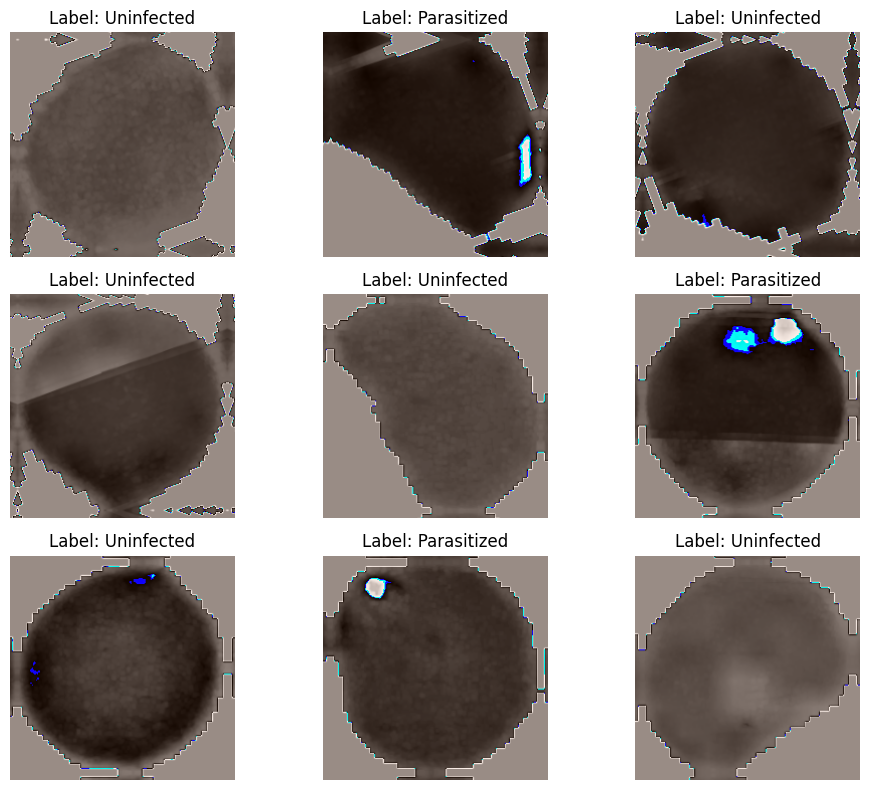

In [28]:
# 4) SHOW SAMPLE IMAGES FROM THE DATASET
###############################################################################
# If you are using tf.data.Dataset:
sample_batch = next(iter(train_ds))  # One batch => (images, labels)
images, labels = sample_batch

# Convert to numpy arrays (if still tf Tensors)
images = images.numpy()
labels = labels.numpy()

# Display the first 9 images in a grid (3x3)
plt.figure(figsize=(10,8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    # Convert from any preprocessing if needed; e.g. if you used ResNet50 preprocess_input,
    # the pixel values might be scaled. If so, you may want to revert or just directly show:
    display_img = images[i]
    # For a quick fix, if you know your pipeline ended up with values around -128..+128,
    # you might do something like:
    # display_img = (display_img - display_img.min()) / (display_img.max() - display_img.min())

    # But if you stored original images before preprocess, you can show them directly:
    plt.imshow(display_img.astype('uint8'))

    label_str = "Parasitized" if labels[i] == 1 else "Uninfected"
    plt.title(f"Label: {label_str}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
# 4. MODEL BUILDING & TRAINING (TRANSFER LEARNING + FINE-TUNING)
################################################################################

EPOCHS = 20  # initial training
FINE_TUNE_EPOCHS = 20
initial_lr = 1e-4
fine_tune_lr = 1e-5

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

def build_transfer_model(base_arch, input_shape=(224,224,3), num_units=128, dropout_rate=0.5):
    """Constructs a transfer learning model with advanced classifier on top."""
    if base_arch == 'VGG16':
        base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    elif base_arch == 'ResNet50':
        base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    elif base_arch == 'MobileNetV2':
        base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    elif base_arch == 'EfficientNetB0':
        base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    else:
        raise ValueError("Unknown base_arch")

    base_model.trainable = False  # freeze initially
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(num_units, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

architectures = ['VGG16','ResNet50','MobileNetV2','EfficientNetB0']
trained_models = {}

for arch in architectures:
    print(f"\n===== Building & Training {arch} Model (Base Frozen) =====")
    tf.keras.backend.clear_session()
    model = build_transfer_model(arch, (IMG_HEIGHT, IMG_WIDTH, 3), num_units=128, dropout_rate=0.5)
    model.compile(
        optimizer=Adam(learning_rate=initial_lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    # Initial Training
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[reduce_lr, early_stop],
        verbose=1
    )

    # Fine-Tune: unfreeze some layers & reduce LR
    print(f"Fine-tuning {arch} ...")
    # Unfreeze top ~20% of layers
    num_layers = len(model.layers)
    unfreeze_from = int(0.8 * num_layers)
    for i, layer in enumerate(model.layers):
        if i >= unfreeze_from:
            layer.trainable = True

    model.compile(
        optimizer=Adam(learning_rate=fine_tune_lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    history_ft = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=FINE_TUNE_EPOCHS,
        callbacks=[reduce_lr, early_stop],
        verbose=1
    )
    trained_models[arch] = model

print("\nAll models trained & fine-tuned.")


===== Building & Training VGG16 Model (Base Frozen) =====
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 24s 111ms/step - accuracy: 0.5630 - loss: 0.8627 - val_accuracy: 0.8133 - val_loss: 0.3967 - learning_rate: 1.0000e-04
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.7765 - loss: 0.4889 - val_accuracy: 0.8333 - val_loss: 0.3524 - learning_rate: 1.0000e-04
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.8193 - loss: 0.4074 - val_accuracy: 0.8533 - val_loss: 0.3366 - learning_rate: 1.0000e-04
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.8157 - loss: 0.4191 - val_accuracy: 0.8683 - val_loss: 0.3114 - learning_rate: 1.0000e-04
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.8438 - loss: 0.3625 - val_accuracy: 0.8617 - val_loss: 0.3181 - learning_rate: 1.0000e-04
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.8508 - loss: 0.3519 - val_accur


==== VGG16 ====
Accuracy:    0.8633
Precision:   0.9504
Recall:      0.7667
F1-score:    0.8487
Specificity: 0.9600
MCC:         0.7406
ROC AUC:     0.9565
PR AUC:      0.9532
Confusion Matrix:
 [[288  12]
 [ 70 230]]


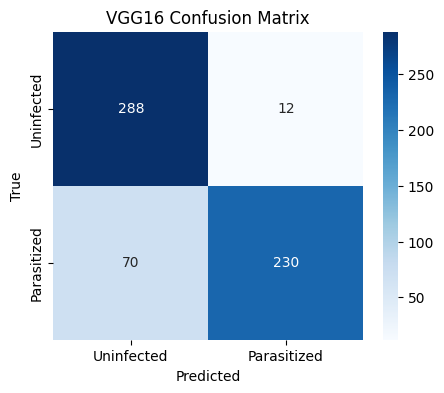


==== ResNet50 ====
Accuracy:    0.9067
Precision:   0.9586
Recall:      0.8500
F1-score:    0.9011
Specificity: 0.9633
MCC:         0.8186
ROC AUC:     0.9727
PR AUC:      0.9740
Confusion Matrix:
 [[289  11]
 [ 45 255]]


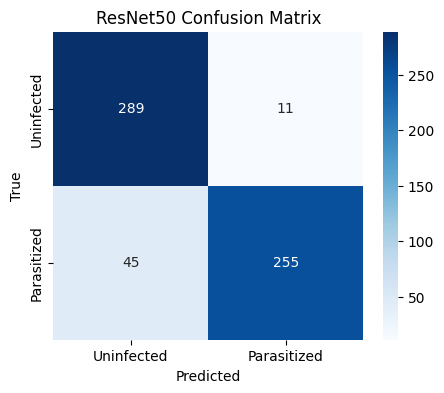


==== MobileNetV2 ====
Accuracy:    0.8250
Precision:   0.7614
Recall:      0.9467
F1-score:    0.8440
Specificity: 0.7033
MCC:         0.6701
ROC AUC:     0.9321
PR AUC:      0.9331
Confusion Matrix:
 [[211  89]
 [ 16 284]]


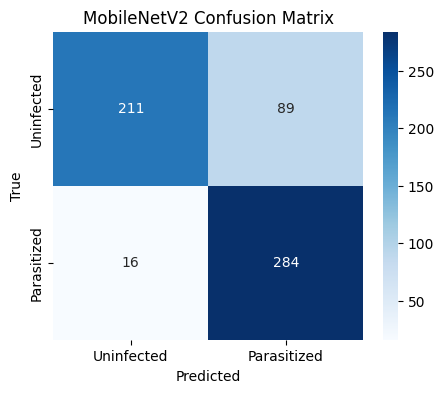


==== EfficientNetB0 ====
Accuracy:    0.9283
Precision:   0.9541
Recall:      0.9000
F1-score:    0.9262
Specificity: 0.9567
MCC:         0.8580
ROC AUC:     0.9720
PR AUC:      0.9712
Confusion Matrix:
 [[287  13]
 [ 30 270]]


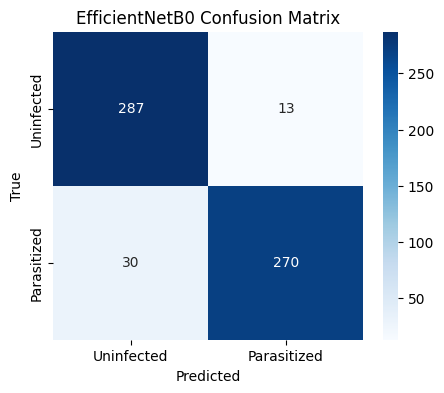

In [14]:
# 5. EVALUATION: ACCURACY, PRECISION, RECALL, F1, SPECIFICITY, MCC, AUC, PR AUC
################################################################################

def evaluate_model(model, dataset, model_name="Model"):
    y_true_all, y_pred_prob_all = [], []
    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        y_true_all.extend(labels.numpy().flatten())
        y_pred_prob_all.extend(preds.flatten())
    y_true_all = np.array(y_true_all)
    y_pred_prob_all = np.array(y_pred_prob_all)
    y_pred_bin = (y_pred_prob_all >= 0.5).astype(int)

    acc  = accuracy_score(y_true_all, y_pred_bin)
    prec = precision_score(y_true_all, y_pred_bin)
    rec  = recall_score(y_true_all, y_pred_bin)
    f1   = f1_score(y_true_all, y_pred_bin)
    auc_ = roc_auc_score(y_true_all, y_pred_prob_all)
    cm   = confusion_matrix(y_true_all, y_pred_bin)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn+fp) > 0 else 0
    mcc = matthews_corrcoef(y_true_all, y_pred_bin)
    pr_auc = average_precision_score(y_true_all, y_pred_prob_all)

    print(f"\n==== {model_name} ====")
    print(f"Accuracy:    {acc:.4f}")
    print(f"Precision:   {prec:.4f}")
    print(f"Recall:      {rec:.4f}")
    print(f"F1-score:    {f1:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"MCC:         {mcc:.4f}")
    print(f"ROC AUC:     {auc_:.4f}")
    print(f"PR AUC:      {pr_auc:.4f}")
    print("Confusion Matrix:\n", cm)
    return cm

def plot_confusion_matrix(cm, model_name="Model"):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Uninfected','Parasitized'],
                yticklabels=['Uninfected','Parasitized'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Evaluate each model on test_ds
for arch, model in trained_models.items():
    cm_test = evaluate_model(model, test_ds, model_name=arch)
    plot_confusion_matrix(cm_test, model_name=arch)



=== Grad-CAM on VGG16, last conv layer: block5_conv3 ===


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


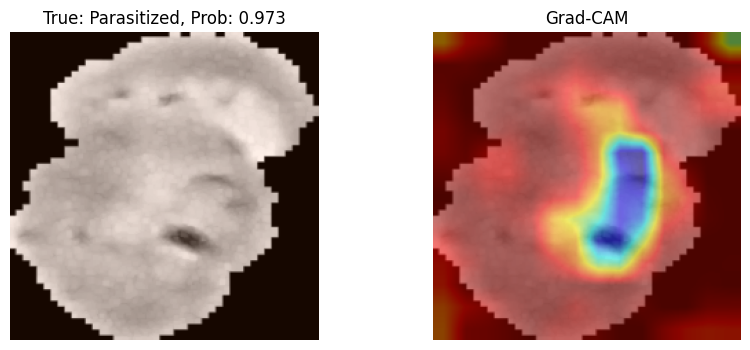

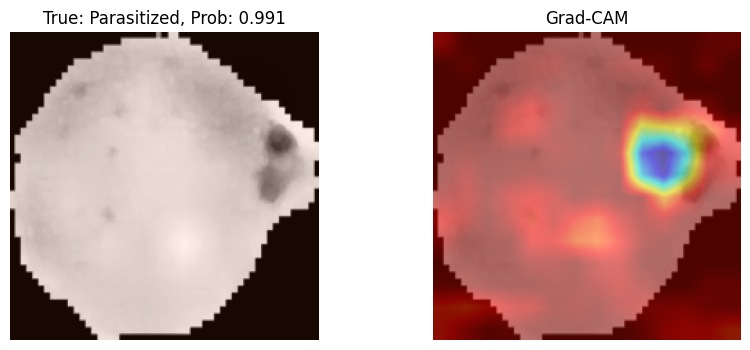

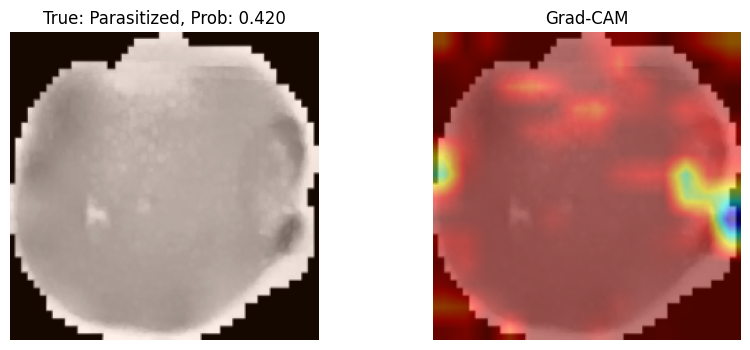


=== Grad-CAM on ResNet50, last conv layer: conv5_block3_out ===


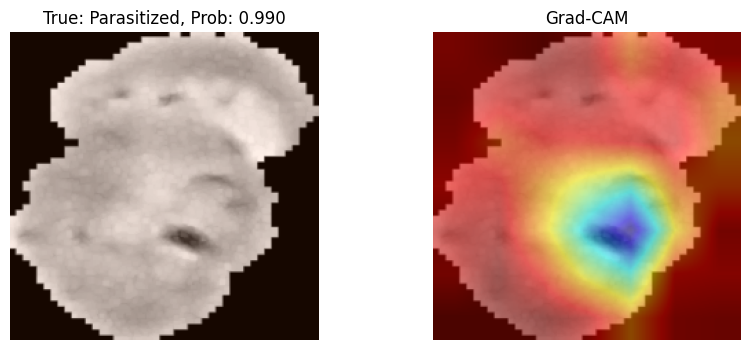

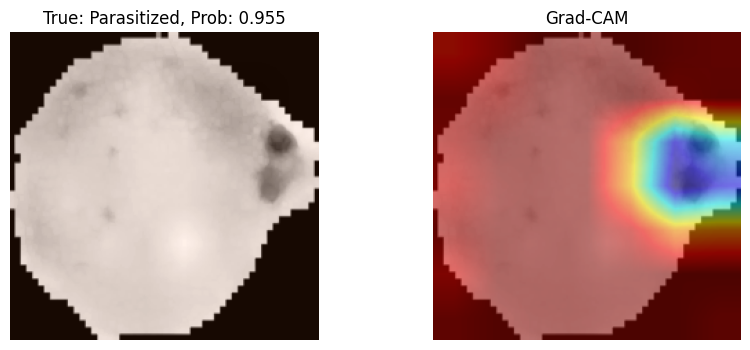

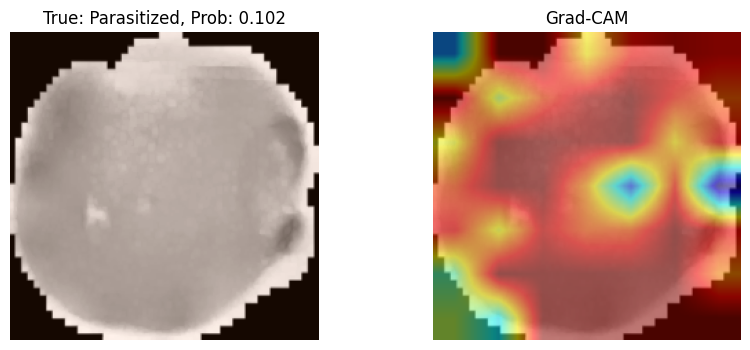


=== Grad-CAM on MobileNetV2, last conv layer: Conv_1 ===


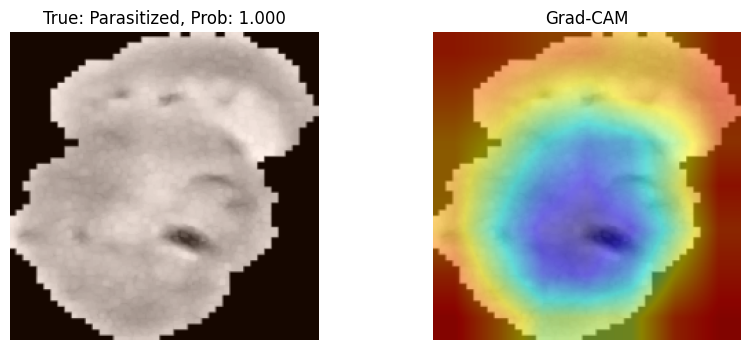

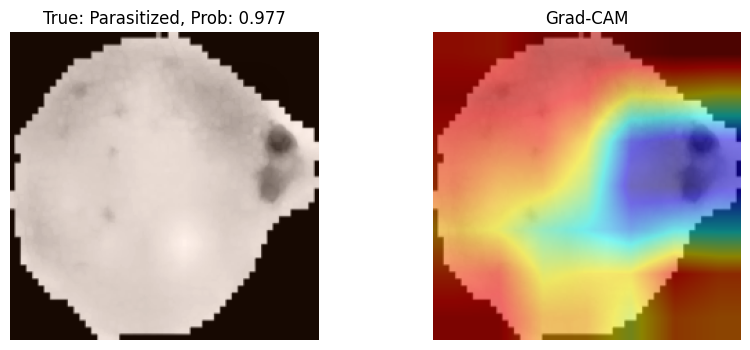

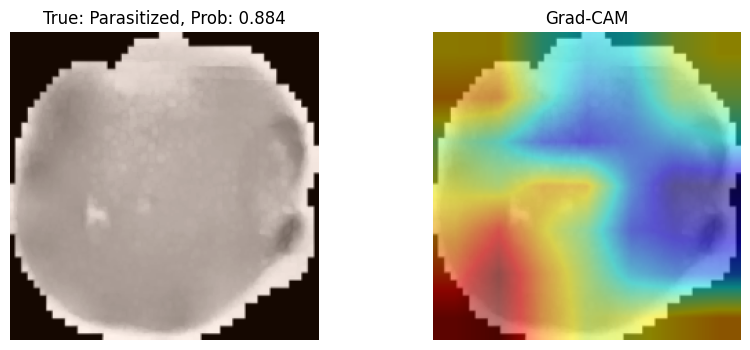


=== Grad-CAM on EfficientNetB0, last conv layer: top_conv ===


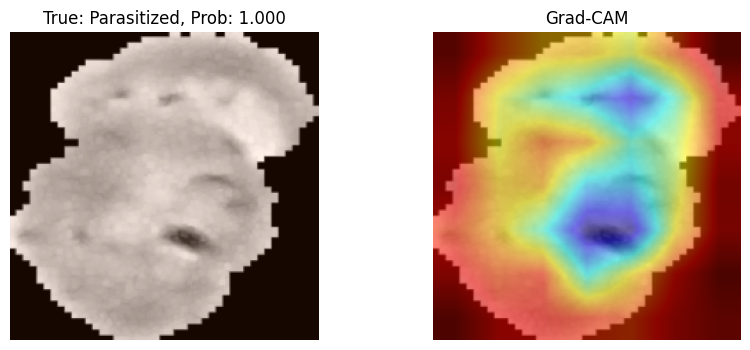

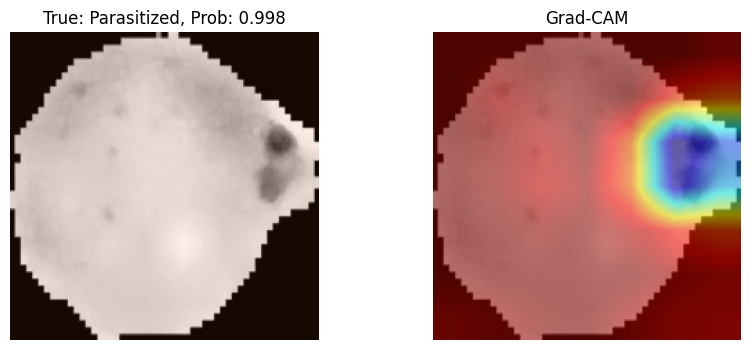

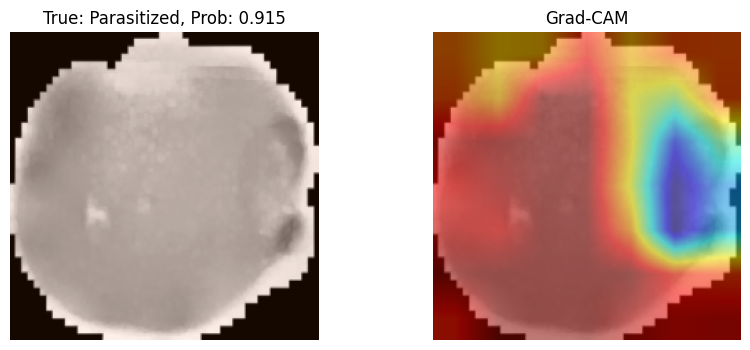

In [17]:
# 6. GRAD-CAM FOR EACH MODEL
################################################################################

# Last convolution layer names for standard architectures:
last_conv_dict = {
    "VGG16": "block5_conv3",
    "ResNet50": "conv5_block3_out",
    "MobileNetV2": "Conv_1",
    "EfficientNetB0": "top_conv"
}

def make_gradcam_heatmap(model, img_array, last_conv_layer_name):
    # direct approach: no searching
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.models.Model([model.inputs],
                                       [last_conv_layer.output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)
        # for a binary classification, output[0] is the probability of class 1
        predicted_class_channel = predictions[:, 0]
    grads = tape.gradient(predicted_class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:,:,i] *= pooled_grads[i]
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) == 0:
        heatmap = np.zeros_like(heatmap)
    else:
        heatmap /= np.max(heatmap)
    return heatmap

def superimpose_heatmap(heatmap, original_img, alpha=0.4):
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(original_img, 1-alpha, heatmap_color, alpha, 0)
    return overlay

# We'll pick a few images from test_ds to visualize
test_batch = next(iter(test_ds))
test_images, test_labels = test_batch
test_images = test_images.numpy()
test_labels = test_labels.numpy()

for arch, model in trained_models.items():
    conv_name = last_conv_dict[arch]
    print(f"\n=== Grad-CAM on {arch}, last conv layer: {conv_name} ===")
    for i in range(min(3, len(test_images))):
        input_img = np.expand_dims(test_images[i], axis=0)
        prob = model.predict(input_img, verbose=0)[0][0]
        heatmap = make_gradcam_heatmap(model, input_img, conv_name)

        # convert model-preprocessed image to 0..255 for display
        disp_img = test_images[i].copy()
        min_val, max_val = disp_img.min(), disp_img.max()
        # If the image is in [-something, +something], we normalize it:
        if max_val > min_val:
            disp_img = (disp_img - min_val)/(max_val - min_val)
        disp_img = (disp_img*255).astype(np.uint8)

        overlay = superimpose_heatmap(heatmap, disp_img, alpha=0.5)

        label_str = "Parasitized" if test_labels[i] == 1 else "Uninfected"
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.title(f"True: {label_str}, Prob: {prob:.3f}")
        plt.imshow(disp_img)
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.title("Grad-CAM")
        plt.imshow(overlay)
        plt.axis('off')
        plt.show()

In [19]:
# HYPERPARAMETER TUNING WITH KERAS TUNER
# (Append this after your Grad-CAM code)
###############################################################################

# If not already installed:
# !pip install keras-tuner

import keras_tuner as kt

# Let's define a function that the tuner will call to build a model
# (We assume you have a build_transfer_model(base_arch, input_shape, units, dropout_rate) function)
# We'll allow the tuner to search over architecture, number of units, dropout, and initial LR.

def build_tuned_model(hp):
    # Choose architecture from your four options
    base_arch = hp.Choice('architecture', ['VGG16', 'ResNet50', 'MobileNetV2', 'EfficientNetB0'])

    num_units = hp.Int('num_units', min_value=64, max_value=256, step=64)
    # Hyperparameters to tune
    dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)
    learning_rate = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])

    # Build the model with these hyperparameters
    model = build_transfer_model(
        base_arch,
        input_shape=(224,224,3),
        dropout_rate=dropout_rate
    )

    # Freeze base for initial training (like your normal approach)
    model.compile(
        optimizer=Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


# Let's create a tuner object. We'll use Hyperband for demonstration:
tuner = kt.Hyperband(
    build_tuned_model,
    objective='val_accuracy',
    max_epochs=20,            # for demonstration (you can increase)
    factor=3,
    directory='tuner_dir',
    project_name='malaria_tuning'
)

# We'll define a small callback to stop early if val_accuracy doesn't improve
stop_early = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True, verbose=1)

# Now we run the tuner search on your train_ds and val_ds (already defined in the environment).
# WARNING: This can be time-consuming if you have a large dataset or many hyperparams.
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=20,      # short for demo
    callbacks=[stop_early],
    verbose=1
)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found:")
print(best_hp.values)

Trial 30 Complete [00h 01m 59s]
val_accuracy: 0.903333306312561

Best val_accuracy So Far: 0.9449999928474426
Total elapsed time: 00h 42m 02s
Best hyperparameters found:
{'architecture': 'EfficientNetB0', 'num_units': 64, 'dropout_rate': 0.6000000000000001, 'learning_rate': 0.0005, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}


In [20]:
# Build the final model from these best hyperparameters
best_model = tuner.hypermodel.build(best_hp)
best_model.summary()

# Retrain or fine-tune the best model more extensively if desired
history_best = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[stop_early],
    verbose=1
)

# Evaluate on test_ds
print("\nEvaluating best tuned model on test set...")
test_loss, test_acc = best_model.evaluate(test_ds, verbose=0)
print(f"Tuned model test accuracy: {test_acc:.4f}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,219,300 (16.10 MB)

 Trainable params: 166,913 (652.00 KB)

 Non-trainable params: 4,052,387 (15.46 MB)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 46s 158ms/step - accuracy: 0.7785 - loss: 0.5771 - val_accuracy: 0.8983 - val_loss: 0.2513
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.8674 - loss: 0.3535 - val_accuracy: 0.9217 - val_loss: 0.2128
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.8744 - loss: 0.3353 - val_accuracy: 0.9267 - val_loss: 0.1901
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.8735 - loss: 0.3188 - val_accuracy: 0.9333 - val_loss: 0.2018
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.8949 - loss: 0.2711 - val_accuracy: 0.9283 - val_loss: 0.2066
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.8851 - loss: 0.2783 - val_accuracy: 0.9350 - val_loss: 0.1745
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.8822 - loss: 0.2802 - val_accuracy: 0.9250 - val_loss: 0.1922
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.8947 - loss: 0.2632 -

In [35]:
import numpy as np
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, matthews_corrcoef, average_precision_score
)

print("\n\n==================== CROSS-VALIDATION ADD-ON ====================\n")

# 1) GATHER ALL IMAGES FROM data_small (train/val/test) INTO A SINGLE LIST
#    We'll unify them so we can do k-fold splits ignoring your previous manual split.

cv_image_paths = []
cv_labels = []

for subdir in ["train", "val", "test"]:
    parasitized_path = os.path.join("data_small", subdir, "Parasitized")
    uninfected_path = os.path.join("data_small", subdir, "Uninfected")

    if os.path.exists(parasitized_path):
        for f in os.listdir(parasitized_path):
            if f.endswith(".png"):
                cv_image_paths.append(os.path.join(parasitized_path, f))
                cv_labels.append(1)

    if os.path.exists(uninfected_path):
        for f in os.listdir(uninfected_path):
            if f.endswith(".png"):
                cv_image_paths.append(os.path.join(uninfected_path, f))
                cv_labels.append(0)

cv_image_paths = np.array(cv_image_paths)
cv_labels = np.array(cv_labels)
print(f"Found {len(cv_image_paths)} total images in data_small (train+val+test).")
print(f"  Parasitized count: {np.sum(cv_labels==1)}")
print(f"  Uninfected count:  {np.sum(cv_labels==0)}")

# 2) DEFINE A SEPARATE PIPELINE FOR CROSS-VALIDATION
#    We'll replicate your advanced pipeline logic (CLAHE + dilation + augmentation)
#    but in functions that accept arbitrary file subsets from the folds.

def load_image_cv(path, label):
    """Load and resize image, cast to uint8 so CLAHE sees 8-bit."""
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.uint8)
    return img, label

def preprocess_train_cv(image, label):
    """CLAHE + dilation + data augmentation + ResNet-like preprocess."""
    image = tf.numpy_function(apply_clahe_and_dilation, [image], tf.uint8)
    image.set_shape((IMG_HEIGHT, IMG_WIDTH, 3))
    image = data_augmentation(image, training=True)  # from your existing data_augmentation
    image = tf.keras.applications.resnet50.preprocess_input(tf.cast(image, tf.float32))
    return image, label

def preprocess_val_cv(image, label):
    """CLAHE + dilation (no aug) + ResNet-like preprocess."""
    image = tf.numpy_function(apply_clahe_and_dilation, [image], tf.uint8)
    image.set_shape((IMG_HEIGHT, IMG_WIDTH, 3))
    image = tf.keras.applications.resnet50.preprocess_input(tf.cast(image, tf.float32))
    return image, label

def build_cv_dataset(paths, labels, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=42)
    ds = ds.map(load_image_cv, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(preprocess_train_cv, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(preprocess_val_cv, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

# 3) CROSS-VALIDATION LOOP
#    We'll do a short example with 3 folds to not be too long. Adjust as desired.

from tensorflow.keras.applications import (
    VGG16, ResNet50, MobileNetV2, EfficientNetB0
)

num_folds = 3
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_architectures = ['VGG16','ResNet50','MobileNetV2','EfficientNetB0']

all_arch_cv_results = {}

for arch in cv_architectures:
    print(f"\n#### CROSS-VALIDATION for {arch} ####")
    fold_metrics_list = []
    fold_idx = 1

    for train_idx, val_idx in skf.split(cv_image_paths, cv_labels):
        print(f"\n--- Fold {fold_idx}/{num_folds} for {arch} ---")

        # Prepare fold subsets
        X_train_cv = cv_image_paths[train_idx]
        y_train_cv = cv_labels[train_idx]
        X_val_cv   = cv_image_paths[val_idx]
        y_val_cv   = cv_labels[val_idx]

        # Build tf.data datasets
        train_fold_ds = build_cv_dataset(X_train_cv, y_train_cv, shuffle=True, augment=True)
        val_fold_ds   = build_cv_dataset(X_val_cv,   y_val_cv,   shuffle=False, augment=False)

        # Build model (reuse build_transfer_model from your code)
        # We'll do a shorter training for demonstration
        tf.keras.backend.clear_session()
        model_cv = build_transfer_model(arch, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_units=128, dropout_rate=0.5)
        model_cv.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

        # Callbacks
        es_cv = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
        rl_cv = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=1e-7, verbose=1)

        # Initial training (frozen base)
        model_cv.fit(
            train_fold_ds,
            validation_data=val_fold_ds,
            epochs=5,  # shorter for demonstration
            callbacks=[es_cv, rl_cv],
            verbose=1
        )

        # Fine-tune top ~20% layers
        num_layers = len(model_cv.layers)
        unfreeze_from = int(0.8 * num_layers)
        for i, layer in enumerate(model_cv.layers):
            if i >= unfreeze_from:
                layer.trainable = True
        model_cv.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
        print("Fine-tuning top layers...")
        model_cv.fit(
            train_fold_ds,
            validation_data=val_fold_ds,
            epochs=3,  # short for demonstration
            callbacks=[es_cv, rl_cv],
            verbose=1
        )

        # Evaluate on this fold
        y_true_fold, y_prob_fold = [], []
        for imgs, lbls in val_fold_ds:
            preds = model_cv.predict(imgs, verbose=0)
            y_true_fold.extend(lbls.numpy().flatten())
            y_prob_fold.extend(preds.flatten())

        y_true_fold = np.array(y_true_fold)
        y_prob_fold = np.array(y_prob_fold)
        y_pred_bin = (y_prob_fold >= 0.5).astype(int)

        # Metrics
        acc_fold  = accuracy_score(y_true_fold, y_pred_bin)
        prec_fold = precision_score(y_true_fold, y_pred_bin)
        rec_fold  = recall_score(y_true_fold, y_pred_bin)
        f1_fold   = f1_score(y_true_fold, y_pred_bin)
        auc_fold  = roc_auc_score(y_true_fold, y_prob_fold)
        cm_fold   = confusion_matrix(y_true_fold, y_pred_bin)
        tn, fp, fn, tp = cm_fold.ravel()
        spec_fold = tn/(tn+fp) if (tn+fp)>0 else 0
        mcc_fold  = matthews_corrcoef(y_true_fold, y_pred_bin)
        pr_auc_fold = average_precision_score(y_true_fold, y_prob_fold)

        fold_metrics = {
            'acc': acc_fold,
            'prec': prec_fold,
            'rec': rec_fold,
            'f1': f1_fold,
            'auc': auc_fold,
            'spec': spec_fold,
            'mcc': mcc_fold,
            'pr_auc': pr_auc_fold
        }
        fold_metrics_list.append(fold_metrics)

        print(f"\nFold {fold_idx} metrics for {arch}:")
        print(f"  Accuracy: {acc_fold:.4f}, Precision: {prec_fold:.4f}, Recall: {rec_fold:.4f}, F1: {f1_fold:.4f}")
        print(f"  Specificity: {spec_fold:.4f}, MCC: {mcc_fold:.4f}, ROC AUC: {auc_fold:.4f}, PR AUC: {pr_auc_fold:.4f}")
        print("  Confusion Matrix:\n", cm_fold)

        fold_idx += 1

    # Summarize CV results across folds
    accs  = [m['acc']  for m in fold_metrics_list]
    precs = [m['prec'] for m in fold_metrics_list]
    recs  = [m['rec']  for m in fold_metrics_list]
    f1s   = [m['f1']   for m in fold_metrics_list]
    aucs  = [m['auc']  for m in fold_metrics_list]
    specs = [m['spec'] for m in fold_metrics_list]
    mccs  = [m['mcc']  for m in fold_metrics_list]
    praucs= [m['pr_auc'] for m in fold_metrics_list]

    print(f"\n=== {arch} Cross-Validation Summary ===")
    print(f"Accuracy:    {np.mean(accs):.4f} ± {np.std(accs):.4f}")
    print(f"Precision:   {np.mean(precs):.4f} ± {np.std(precs):.4f}")
    print(f"Recall:      {np.mean(recs):.4f} ± {np.std(recs):.4f}")
    print(f"F1-Score:    {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
    print(f"Specificity: {np.mean(specs):.4f} ± {np.std(specs):.4f}")
    print(f"MCC:         {np.mean(mccs):.4f} ± {np.std(mccs):.4f}")
    print(f"ROC AUC:     {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")
    print(f"PR AUC:      {np.mean(praucs):.4f} ± {np.std(praucs):.4f}")

    all_arch_cv_results[arch] = fold_metrics_list

print("\nCROSS-VALIDATION DONE FOR ALL FOUR MODELS!")
print("=============================================================\n")



==================== CROSS-VALIDATION ADD-ON ====================

Found 6000 total images in data_small (train+val+test).
  Parasitized count: 3000
  Uninfected count:  3000

#### CROSS-VALIDATION for VGG16 ####

--- Fold 1/3 for VGG16 ---
Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.5934 - loss: 0.8787 - val_accuracy: 0.7570 - val_loss: 0.5004 - learning_rate: 1.0000e-04
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.7691 - loss: 0.5221 - val_accuracy: 0.8065 - val_loss: 0.4250 - learning_rate: 1.0000e-04
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.8059 - loss: 0.4346 - val_accuracy: 0.7985 - val_loss: 0.4181 - learning_rate: 1.0000e-04
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.8314 - loss: 0.4007 - val_accuracy: 0.8105 - val_loss: 0.3951 - learning_rate: 1.0000e-04
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.8287 - loss: 0.4011 - val_accuracy: 0.8410 - val_loss: 0.